# All water supply systems

CEDAE is the coorporation that provides drinking water and wastewater services for the Rio de Janeiro State.
They provide plenty of data regarding the quality of the water for the press and for the population, due to laws imposed by the Ministry of Health of Brazil.

Here we aim to extract, compile and analyse data from all water supply systems (that we'll be denoting by the acronym *WSS*) being monitored by CEDAE. This data is also available on their webpage. The data of every WSS is routinely gathered and anually compiled into a single report.

Unfortunately, this data is not presented in high granularity, as only the mean of the measurements per month are available. Although this data has been monitored and available since 2004, we have less data samples (\~204) than the number of daily recorded samples in a single year (\~365).

The data available contains the following parameters:

* Physical and Chemical
  * Haze (*turbidez*)
  * Aparent color
  * Residual chlorine
* Bacteriological
  * Total coliforms (before and after recollection)
  * E. coli (before and after recollection)

The plan is to do the following sequence of tasks:

1. Download the HTML page where all links to PDFs reside
2. Parse the HTML page and extract any link to PDFs and its metadata (year and WSS)
3. Download each PDF into a list of well-formated data frames
4. Make all these data frames uniform in terms of columns, units and representation
4. Export these data frames as CSV for later analysis in Tableau or in Python

## 1. Download the HTML page

First we download the HTML using the `urllib.request.urlopen` method. It returns a file pointer, from which the page can be read as a stream of bytes, and decoded to UTF-8, the default string encoding for Python (and the modern internet, pretty much).

In [1]:
import urllib.request

with urllib.request.urlopen('https://cedae.com.br/relatorioanual') as fp:
    page = fp.read().decode() # Read from page and decode to UTF-8 string

You can check that we got indeed the HTML for the page:

In [2]:
print(page[:80])

<!DOCTYPE html>
<html  lang="pt-BR">
<head id="Head">
<!--*******************


## 2. Parse the HTML page

For this task, we'll be using the `HTMLParser` class from the `html.parser` module, which allows us to specify callbacks for when the parser reads the beggining tags (`<...>`), in-between text (`<a> ... </a>`), and their ending tags (`</...>`).

After analysing the source code for the page we're parsing, we notice that all links that interest us are contained in tables, particularly inside `<td>` tags. Moreover, every table has a top row whose class is `thead` (probably for short for "table head") containing the year of the reports.

For building our custom parser, we inherit the `HTMLParser`.

In [3]:
import html.parser
from datetime import datetime

class MyHTMLParser(html.parser.HTMLParser):
    
    def __init__(self):
        super().__init__()
        self.in_td = False
        self.in_thead = False
        self.year = None
        self.link = None
        self.links = {}
    
    def handle_starttag(self, tag, attrs):
        if tag == 'td':
            self.in_td = True
        elif tag == 'a':
            links = [v for k, v in attrs if k == 'href']
            if links:
                assert len(links) == 1, links
                self.link = links[0]
        elif tag == 'tr' and ('class', 'thead') in attrs:
            self.in_thead = True
    
    def handle_data(self, data):
        if self.in_thead:
            for number in [int(s) for s in data.split() if s.isdigit()]:
                # CEDAE was created in 1975
                if 1975 <= number <= datetime.now().year:
                    self.year = number
        elif self.in_td and self.link is not None:
            assert self.year is not None
            data = data.strip()
            assert len(data) > 0
            if self.year not in self.links:
                self.links[self.year] = {}
            assert data not in self.links[self.year], self.links[self.year][data]
            self.links[self.year][data] = self.link
    
    def handle_endtag(self, tag):
        if tag == 'td':
            self.in_td = False
        elif tag == 'a':
            self.link = None
        elif tag == 'tr':
            self.in_thead = False
        elif tag == 'table':
            self.year = None

We now construct a parser instance and feed it with the contents of the HTML page.

In [4]:
parser = MyHTMLParser()
parser.feed(page)

The links are stored in the `links` field. It is a dictionary of dictionaries of strings. It is first indexed by the year of the reports, and second by the name of the water supply system, resulting in the link to the PDF of the annual report corresponding to that WSS in that year.

In [5]:
links = parser.links

Let's check the years we were able to obtain.

In [6]:
links.keys()

dict_keys([2020, 2019, 2018, 2017, 2016])

And all the water supply systems.

In [7]:
def wss_generator():
    for year, reports in links.items():
        for wss, link in reports.items():
            yield wss

set(wss_generator())

{'Afonso Viseu',
 'Alto São José',
 'Alto de São José',
 'Andrade Costa',
 'Andrade Pinto',
 'Anta',
 'Aparecida',
 'Aperibé',
 'Arrozal',
 'Atafona',
 'Avelar',
 'Banquete',
 'Barcelos',
 'Barra Do Açu',
 'Barra Do Itabapoana',
 'Barra de Itabapoana',
 'Barra do Açu',
 'Barra do Itabapoana',
 'Beija-Flor',
 'Beijaflor',
 'Bom Jardim',
 'Bom Jesus',
 'Bom Jesus do Itabapoana',
 'Bonsucesso',
 'Cabo Severino',
 'Cacaria',
 'Cajueiro Degredo',
 'Cajueiro/Degredo',
 'Cajueirodegredo',
 'Cambuci',
 'Carabucu',
 'Carabuçu',
 'Carabuçú',
 'Carapebus',
 'Cardoso Moreira',
 'Cascata Dos Amores',
 'Cascata dos Amores',
 'Cimento Paraiso',
 'Cimento Paraíso',
 'Conrado',
 'Cordeiro',
 'Cordeiro/Cantagado',
 'Coronel Teixeira',
 'Coronel Teixeira/Batatal',
 'Coronel Teixeirabatatal',
 'Demétrio Ribeiro',
 'Dois Murinhos',
 'Duas Barras',
 'Euclidelândia',
 'Fazenda Da Grama',
 'Fazenda da Grama',
 'Ferreiros',
 'Fábrica Brasil',
 'Gargau',
 'Gargaú',
 'Grussai',
 'Grussaí',
 'Guandu',
 'Guandú',


We notice that there are a lot of duplicates, due to different casing. Let's make it uniform by changing all to title case (as in `Barra Da Tijuca`).

In [8]:
new_links = {}
for year, reports in links.items():
    new_reports = {}
    for wss, link in reports.items():
        new_reports[wss.title()] = link
    new_links[year] = new_reports
links = new_links

Let's check if we were able to remove duplicates...

In [9]:
set(wss_generator())

{'Afonso Viseu',
 'Alto De São José',
 'Alto São José',
 'Andrade Costa',
 'Andrade Pinto',
 'Anta',
 'Aparecida',
 'Aperibé',
 'Arrozal',
 'Atafona',
 'Avelar',
 'Banquete',
 'Barcelos',
 'Barra De Itabapoana',
 'Barra Do Açu',
 'Barra Do Itabapoana',
 'Beija-Flor',
 'Beijaflor',
 'Bom Jardim',
 'Bom Jesus',
 'Bom Jesus Do Itabapoana',
 'Bonsucesso',
 'Cabo Severino',
 'Cacaria',
 'Cajueiro Degredo',
 'Cajueiro/Degredo',
 'Cajueirodegredo',
 'Cambuci',
 'Carabucu',
 'Carabuçu',
 'Carabuçú',
 'Carapebus',
 'Cardoso Moreira',
 'Cascata Dos Amores',
 'Cimento Paraiso',
 'Cimento Paraíso',
 'Conrado',
 'Cordeiro',
 'Cordeiro/Cantagado',
 'Coronel Teixeira',
 'Coronel Teixeira/Batatal',
 'Coronel Teixeirabatatal',
 'Demétrio Ribeiro',
 'Dois Murinhos',
 'Duas Barras',
 'Euclidelândia',
 'Fazenda Da Grama',
 'Ferreiros',
 'Fábrica Brasil',
 'Gargau',
 'Gargaú',
 'Grussai',
 'Grussaí',
 'Guandu',
 'Guandú',
 'Gávea Pequena',
 'Imunana Laranjal',
 'Ipiabas',
 'Itabapoana',
 'Itakamosi',
 'Ita

We were able to remove some duplicates (like `Barra Do Itabapoana` and `Barra do Itabapoana`), but some only differ by a character or two (like `Beija-Flor` and `Beijaflor`). In order to identify these similar strings, we'll be using the Levenshtein distance and building a distance matrix so we can easily spot duplicates.

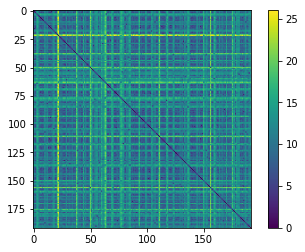

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import Levenshtein

wsss = list(set(wss_generator()))
nwsss = len(wsss)
dmatrix = np.zeros(shape=(nwsss, nwsss), dtype=np.int64)

for i, wss_i in enumerate(wsss):
    for j, wss_j in enumerate(wsss):
        dmatrix[i][j] = Levenshtein.distance(wss_i, wss_j)

plt.imshow(dmatrix)
plt.colorbar()
plt.show()

This plot does not give us good insight about how the Levenshtein distance is distributed across the names. Let's plot a histogram, instead. We'll ignore distance between strings equal to zero because it is not relevant to us. Also, we're only interested in distances lower than 4.

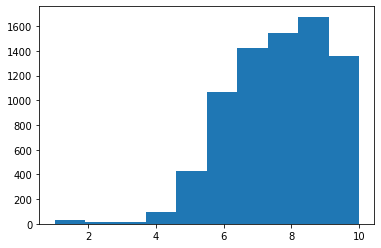

In [11]:
plt.hist(np.triu(dmatrix).flatten(), bins=10, range=(1, 10))
plt.show()

Let's inspect strings at a given Levenshtein distance with the following function.

In [12]:
def wss_at_distance(dist):
    for i, wss_i in enumerate(wsss):
        for j, wss_j in enumerate(wsss):
            if i < j:
                continue  # avoid duplicates
            if dmatrix[i][j] == dist:
                yield wss_i, wss_j

First, strings with 1 edit apart:

In [13]:
print(*wss_at_distance(1), sep='\n')

('Massambara', 'Massambará')
('Santanesia', 'Santanésia')
('Cimento Paraíso', 'Cimento Paraiso')
('Poço Manuel Ribeiro', 'Poço Manoel Ribeiro')
('Lídice', 'Lidice')
('Laje Do Muriaé', 'Lajes Do Muriaé')
('Parapeúna', 'Parapeuna')
('Jacarandá', 'Jacaranda')
('Quininha Batalha', 'Quininha/Batalha')
('Carabuçu', 'Carabucu')
('Jamapara', 'Jamapará')
('Paraíso Do Tobias', 'Paraiso Do Tobias')
('Guandu', 'Guandú')
('Juparana', 'Juparanã')
('Gargau', 'Gargaú')
('Porciuncula', 'Porciúncula')
('São João Do Paraíso', 'São João Do Paraiso')
('Carabuçú', 'Carabuçu')
('Medanha', 'Mendanha')
('Grussaí', 'Grussai')
('São José De Ubá', 'São Jose De Ubá')
('Barra De Itabapoana', 'Barra Do Itabapoana')
('Passa Tres', 'Passa Três')
('Tanguá', 'Tinguá')
('Praca João Pessoa', 'Praça João Pessoa')
('Cajueiro/Degredo', 'Cajueiro Degredo')
('Parque Do Ingá', 'Parque Do Inguá')


Here we notice that a pair cannot be merged: `Tinguá` and `Tanguá`. They, in fact, have their own reports in the same year. Let's ignore those cases with the following filter function.

In [14]:
def have_report_in_same_year(wss1, wss2):
    for year, reports in links.items():
        if wss1 in reports and wss2 in reports:
            return True
    return False

Then we define a new `wss_at_distance` function which make sures the WSSs never have reports in the same year.

In [15]:
def wss_at_distance_v2(dist):
    for wss1, wss2 in wss_at_distance(dist):
        if not have_report_in_same_year(wss1, wss2):
            yield wss1, wss2

Now we take a look at the new list of WSSs with edit distance of 1 and notice that the `Tinguá x Tanguá` pair is now gone.

In [16]:
print(*wss_at_distance_v2(1), sep='\n')

('Massambara', 'Massambará')
('Santanesia', 'Santanésia')
('Cimento Paraíso', 'Cimento Paraiso')
('Poço Manuel Ribeiro', 'Poço Manoel Ribeiro')
('Lídice', 'Lidice')
('Laje Do Muriaé', 'Lajes Do Muriaé')
('Parapeúna', 'Parapeuna')
('Jacarandá', 'Jacaranda')
('Quininha Batalha', 'Quininha/Batalha')
('Carabuçu', 'Carabucu')
('Jamapara', 'Jamapará')
('Paraíso Do Tobias', 'Paraiso Do Tobias')
('Guandu', 'Guandú')
('Juparana', 'Juparanã')
('Gargau', 'Gargaú')
('Porciuncula', 'Porciúncula')
('São João Do Paraíso', 'São João Do Paraiso')
('Carabuçú', 'Carabuçu')
('Medanha', 'Mendanha')
('Grussaí', 'Grussai')
('São José De Ubá', 'São Jose De Ubá')
('Barra De Itabapoana', 'Barra Do Itabapoana')
('Passa Tres', 'Passa Três')
('Praca João Pessoa', 'Praça João Pessoa')
('Cajueiro/Degredo', 'Cajueiro Degredo')
('Parque Do Ingá', 'Parque Do Inguá')


Let's now take a look at distance 2.

In [17]:
print(*wss_at_distance_v2(2), sep='\n')

('Varresai', 'Varre-Sai')
('Poço De Marques', 'Poço Do Marquês')
('Cajueirodegredo', 'Cajueiro Degredo')
('Beija-Flor', 'Beijaflor')
('São João De Ubá', 'São Jose De Ubá')
('Carabuçú', 'Carabucu')
('São José De Ubá', 'São João De Ubá')
('Coronel Teixeira/Batatal', 'Coronel Teixeirabatatal')
('Rio Douro', "Rio D'Ouro")
('Cajueiro/Degredo', 'Cajueirodegredo')


Here we notice that even CEDAE has made a mistake here and mistyped `São José de Ubá` until the year of 2017 as `São João de Ubá`, which doesn't even exist in Rio de Janeiro. If you were to read the report, you'd see that it's written `São José`, not `São João`.

If we were to decide which name is correct, we could rely on the number of times such name was registered. But this method is not fail-proof, because as you can see, even CEDAE took a while to fix their typo. The best way is to let us judge which name is correct.

Next, we'll see those names at distance 3.

In [18]:
print(*wss_at_distance_v2(3), sep='\n')

('São Sebastião Paraíba', 'São Sebastião Do Paraíba')
('Alto De São José', 'Alto São José')
('Poço Do Marquês', 'Poço Marquês')
('Juparana', 'Jacaranda')


Here we observe an interesting case. Although we have seen that `Jucaranda` and `Jacarandá` were similar with 1 edit distance, we haven't effectively stored this information anywhere. Thus, even though `Jacarandá` and `Juparanã` have reports in the same year, `Juparanã` was not merged with `Juparana` and `Jacarandá` was not merged with `Jacaranda`.

What we need to do is create a sort of cluster for each similar word. In the beggining, each cluster has only one name. We'll define a function for providing such initial state, called `new_clusters`.

In [19]:
def new_clusters():
    return {wss: set([wss]) for wss in wsss}

Let's define a new version of `wss_at_distance` which ignores names in the same cluster or with conflicting clusters.

In [20]:
def can_clusters_be_merged(cl1, cl2):
    if cl1 is cl2:
        return False  # cannot merge with itself
    for wss1 in cl1:
        for wss2 in cl2:
            if have_report_in_same_year(wss1, wss2):
                return False
    return True

def wss_at_distance_v3(dist, clusters):
    for wss1, wss2 in wss_at_distance_v2(dist):
        if can_clusters_be_merged(clusters[wss1], clusters[wss2]):
            yield wss1, wss2

The idea is to merge cluster with similar names with distances from 1 to 3.

In [21]:
cls = new_clusters()
for dist in range(1, 4):
    for wss1, wss2 in wss_at_distance_v3(dist, cls):
        new_cluster = cls[wss1].union(cls[wss2])
        for wss in new_cluster:
            cls[wss] = new_cluster

Now let's define a generator for unique clusters (since sets are not hashables, we need to use lists...)

In [22]:
def iter_clusters(clusters):
    visited = []
    clusters = sorted(clusters.values(), key=tuple)
    clusters = sorted(clusters, reverse=True, key=len)
    for cluster in clusters:
        if cluster not in visited:
            visited.append(cluster)
            yield cluster

We then print all the clusters in order of size.

In [23]:
print(*iter_clusters(cls), sep='\n')

{'Cajueiro Degredo', 'Cajueiro/Degredo', 'Cajueirodegredo'}
{'Carabuçu', 'Carabucu', 'Carabuçú'}
{'Poço Marquês', 'Poço Do Marquês', 'Poço De Marques'}
{'São José De Ubá', 'São Jose De Ubá', 'São João De Ubá'}
{'Alto São José', 'Alto De São José'}
{'Barra De Itabapoana', 'Barra Do Itabapoana'}
{'Beija-Flor', 'Beijaflor'}
{'Cimento Paraíso', 'Cimento Paraiso'}
{'Coronel Teixeirabatatal', 'Coronel Teixeira/Batatal'}
{'Gargaú', 'Gargau'}
{'Grussai', 'Grussaí'}
{'Guandu', 'Guandú'}
{'Jacarandá', 'Jacaranda'}
{'Jamapara', 'Jamapará'}
{'Juparanã', 'Juparana'}
{'Laje Do Muriaé', 'Lajes Do Muriaé'}
{'Lidice', 'Lídice'}
{'Massambará', 'Massambara'}
{'Mendanha', 'Medanha'}
{'Parapeuna', 'Parapeúna'}
{'Paraíso Do Tobias', 'Paraiso Do Tobias'}
{'Parque Do Inguá', 'Parque Do Ingá'}
{'Passa Três', 'Passa Tres'}
{'Porciúncula', 'Porciuncula'}
{'Poço Manoel Ribeiro', 'Poço Manuel Ribeiro'}
{'Praca João Pessoa', 'Praça João Pessoa'}
{'Quininha/Batalha', 'Quininha Batalha'}
{'Rio Douro', "Rio D'Ouro"}
{

A somewhat uninteresting statistic we can extract from this is what is the percentage of names which are misspelled. We define it as such:

In [24]:
def misspelled_ratio(clusters):
    total = 0
    misspelled = 0
    for cluster in clusters.values():
        total += len(cluster)           # every name is in a cluster
        misspelled += len(cluster) - 1  # at least one from each cluster is the write spelling
    return misspelled/total

We print it out nicely:

In [25]:
print('{:.2f}% are misspelled'.format(100*misspelled_ratio(cls)))

29.41% are misspelled


As mentioned earlier, this processing is meant only to take misspellings into account. For cases where the edit distance is just to large to grasp similarities, we resort to other methods. Now, let's define a function for selecting the right spelling of each cluster.

In [26]:
def ascii_count(s):
    return len([c for c in s if not c.isascii()])

def last_year(s):
    y = 0
    for year, reports in links.items():
        if s in reports:
            y = year
    return y

def get_right_spelling(cl):
    # Criterium for choosing the right spelling
    # In order of least importance
    s = iter(cl)
    s = sorted(s, key=last_year)    # last year
    s = sorted(s, key=ascii_count)  # number of non-ASCII characters
    s = sorted(s, key=len)          # length
    return s[-1]

Let us see if our criterium are good enough...

In [27]:
for cl in iter_clusters(cls):
    right = get_right_spelling(cl)
    print(cl, '->', right)

{'Cajueiro Degredo', 'Cajueiro/Degredo', 'Cajueirodegredo'} -> Cajueiro/Degredo
{'Carabuçu', 'Carabucu', 'Carabuçú'} -> Carabuçú
{'Poço Marquês', 'Poço Do Marquês', 'Poço De Marques'} -> Poço Do Marquês
{'São José De Ubá', 'São Jose De Ubá', 'São João De Ubá'} -> São José De Ubá
{'Alto São José', 'Alto De São José'} -> Alto De São José
{'Barra De Itabapoana', 'Barra Do Itabapoana'} -> Barra De Itabapoana
{'Beija-Flor', 'Beijaflor'} -> Beija-Flor
{'Cimento Paraíso', 'Cimento Paraiso'} -> Cimento Paraíso
{'Coronel Teixeirabatatal', 'Coronel Teixeira/Batatal'} -> Coronel Teixeira/Batatal
{'Gargaú', 'Gargau'} -> Gargaú
{'Grussai', 'Grussaí'} -> Grussaí
{'Guandu', 'Guandú'} -> Guandú
{'Jacarandá', 'Jacaranda'} -> Jacarandá
{'Jamapara', 'Jamapará'} -> Jamapará
{'Juparanã', 'Juparana'} -> Juparanã
{'Laje Do Muriaé', 'Lajes Do Muriaé'} -> Lajes Do Muriaé
{'Lidice', 'Lídice'} -> Lídice
{'Massambará', 'Massambara'} -> Massambará
{'Mendanha', 'Medanha'} -> Mendanha
{'Parapeuna', 'Parapeúna'} -> P

We can formulate another metric to evaluate how good are our clusters. We'll count how many report each cluster has. Optimally, each cluster should have a report every year. If there are a lot of "holes" in the timeline, or misclassifications, then this number will be smaller.

In [28]:
import numpy as np

def num_of_reports(wss):
    num = 0
    for year, reports in links.items():
        if wss in reports:
            num += 1
    return num

def num_of_reports_in_cluster(cluster):
    num = 0
    for wss in cluster:
        num += num_of_reports(wss)
    return num

def num_of_reports_per_cluster(clusters):
    nums = []
    for cluster in iter_clusters(clusters):
        nums.append(num_of_reports_in_cluster(cluster))
    return np.array(nums, dtype=int)

We then print some statistics about this data and plot it. We also calculate how many clusters have less reports/year than the maximum value.

Minimum: 1.00
Maximum: 5.00
Average: 4.25
27.56% of clusters have less than 5 reports per year


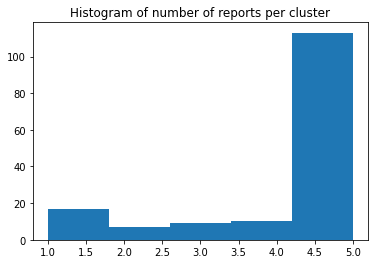

In [29]:
nreps = num_of_reports_per_cluster(cls)
print("Minimum: {:.2f}".format(np.min(nreps)))
print("Maximum: {:.2f}".format(np.max(nreps)))
print("Average: {:.2f}".format(np.average(nreps)))
maxnreps = np.max(nreps)
nrepslessthanmax = nreps[nreps < maxnreps]
print("{:.2f}% of clusters have less than {:d} reports per year".format(
    100*len(nrepslessthanmax)/len(nreps), maxnreps))

plt.hist(nreps, bins=5)
plt.title("Histogram of number of reports per cluster")
plt.show()

Let's compare this data with no processing at all, that is, without clustering similar names.

Minimum: 1.00
Maximum: 5.00
Average: 3.45
55.73% of clusters have less than 5 reports per year


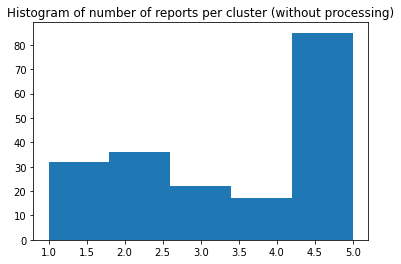

In [30]:
nreps = num_of_reports_per_cluster(new_clusters())
print("Minimum: {:.2f}".format(np.min(nreps)))
print("Maximum: {:.2f}".format(np.max(nreps)))
print("Average: {:.2f}".format(np.average(nreps)))
maxnreps = np.max(nreps)
nrepslessthanmax = nreps[nreps < maxnreps]
print("{:.2f}% of clusters have less than {:d} reports per year".format(
    100*len(nrepslessthanmax)/len(nreps), maxnreps))

plt.hist(nreps, bins=5)
plt.title("Histogram of number of reports per cluster (without processing)")
plt.show()

We see that our processing has greatly improved the number of clusters with yearly reports. We hope to shrink this number even further with more processing. It is our goal to merge clusters with missing reports. Let's see which clusters could be merged, having seen that every water supply system has at most one yearly report.